In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scripts.utils import vpt_smape, vpt_nrmse, vpt_mse, smape_rolling
from scipy.spatial.distance import cdist
from dysts.systems import get_attractor_list
from dysts.flows import __dict__ as flow_models
from dysts.analysis import gp_dim
from dysts.metrics import estimate_kl_divergence
import os

In [2]:
import timesfm

# For Torch
tfm = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="cpu",
          per_core_batch_size=32,
          horizon_len=300,
          num_layers=50,
          use_positional_embedding=False,
          context_len=2048,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
  )

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.


/Users/yuanzhao/anaconda3/envs/TimeFM/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded PyTorch TimesFM, likely because python version is 3.11.11 (main, Dec 11 2024, 10:25:04) [Clang 14.0.6 ].


Fetching 5 files: 100%|██████████| 5/5 [02:29<00:00, 29.81s/it]


In [3]:
granularity = 30
context_lengths = 2**np.arange(6, 13)
forecast_length = 300
#simulation_length = 10000
simulation_length = 100000
rolling_window = 4000
num_ic = 20

# Directory to store trajectories
#trajectory_dir = "trajectories"
trajectory_dir = "long_trajectories"
os.makedirs(trajectory_dir, exist_ok=True)

equation_names = get_attractor_list()
equation_names.remove('FluidTrampoline')
equation_names.remove('HyperLu')
equation_names.remove('SprottMore')
equation_names.remove('StickSlipOscillator')
#equation_names = equation_names[:2]

In [4]:
def mse(y_true, y_pred):
    
    mse = np.mean((y_true - y_pred) ** 2)
    return mse

def mse_rolling(ts1, ts2):

    n = min(ts1.shape[0], ts2.shape[0])
    all_mse = list()
    for i in range(1, n+1):
        mse_val = mse(ts1[:i], ts2[:i])
        all_mse.append(mse_val)

    return np.array(all_mse)

def mae(y_true, y_pred):
    
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

def mae_rolling(ts1, ts2):

    n = min(ts1.shape[0], ts2.shape[0])
    all_mae = list()
    for i in range(1, n+1):
        mae_val = mae(ts1[:i], ts2[:i])
        all_mae.append(mae_val)

    return np.array(all_mae)

In [5]:
average_vpt = dict()
median_vpt = dict()
average_smape = dict()
median_smape = dict()

average_vpt_2 = dict()
median_vpt_2 = dict()
average_smape_2 = dict()
median_smape_2 = dict()

average_cdim = dict()
median_cdim = dict()
average_kl = dict()
median_kl = dict()

average_mse = dict()
median_mse = dict()
average_mae = dict()
median_mae = dict()

In [ ]:
for equation_name in equation_names:

    try:

        # Path to the trajectory file
        trajectory_path = os.path.join(trajectory_dir, f"{equation_name}.npy")

        # Check if the trajectory file already exists
        if os.path.exists(trajectory_path):
            print(f"Loading existing trajectory for {equation_name}...")
            traj = np.load(trajectory_path)
        else:
            # Generate the trajectory
            print(f"Generating trajectory for {equation_name}...")
            model_class = flow_models[equation_name]  # Get the model class dynamically
            model = model_class()  # Instantiate the model
            traj = model.make_trajectory(simulation_length, pts_per_period=granularity)

            # Save the trajectory
            np.save(trajectory_path, traj)
            print(f"Saved trajectory for {equation_name} at {trajectory_path}")

        # normalize the trajectory
        traj = (traj - np.mean(traj, axis=0)) / np.std(traj, axis=0)

        for context_length in context_lengths:

            all_vpt = list() # collecting all vpt for the parroting model
            all_smape_rolling = list() # collecting all smape values across time
            all_vpt_2 = list() # collecting all vpt for the parroting model
            all_smape_rolling_2 = list() # collecting all smape values across time
            all_cdim = list() # collecting all correlation dimensions
            all_kl_dist = list() # collecting all kl divergence values
            all_mse_rolling = list()
            all_mae_rolling = list()

            for i in range(0, len(traj)-context_length-forecast_length, rolling_window):
                if i < rolling_window*num_ic:
                    #print(i//rolling_window)
                    traj_context = traj[i:i+context_length,:]
                    traj_true = traj[i+context_length:i+context_length+forecast_length,:]
                    
                    point_forecast, experimental_quantile_forecast = tfm.forecast(
                        traj_context.transpose(),
                        #freq=[0,0,0],
                    )
                    traj_pred = point_forecast.transpose()

                    for dim in range(traj_true.shape[1]):

                        vpt = vpt_smape(traj_pred[:,dim], traj_true[:,dim]) / granularity
                        smape_val = np.array(smape_rolling(traj_true[:, dim], traj_pred[:,dim]))

                        all_vpt.append(vpt)
                        all_smape_rolling.append(smape_val)

                        mse_val = mse_rolling(traj_true[:, dim], traj_pred[:,dim])
                        all_mse_rolling.append(mse_val)
                        
                        mae_val = mae_rolling(traj_true[:, dim], traj_pred[:,dim])
                        all_mae_rolling.append(mae_val)

                    vpt = vpt_smape(traj_pred.squeeze(), traj_true.squeeze()) / granularity
                    smape_val = np.array(smape_rolling(traj_true, traj_pred))
                    all_vpt_2.append(vpt)
                    all_smape_rolling_2.append(smape_val)
                    
                    kl_dist = estimate_kl_divergence(traj_true, traj_pred)
                    if np.isinf(kl_dist):
                        kl_dist = np.nan
                    all_kl_dist.append(kl_dist)

                    cdim_pred = gp_dim(traj_pred)
                    cdim_true = gp_dim(traj_true)
                    all_cdim.append(np.array([cdim_pred, cdim_true]))

            average_vpt[(equation_name,context_length)] = np.mean(all_vpt)
            median_vpt[(equation_name,context_length)] = np.median(all_vpt)
            average_smape[(equation_name,context_length)] = np.mean(all_smape_rolling, axis=0)
            median_smape[(equation_name,context_length)] = np.median(all_smape_rolling, axis=0)

            average_vpt_2[(equation_name,context_length)] = np.mean(all_vpt_2)
            median_vpt_2[(equation_name,context_length)] = np.median(all_vpt_2)
            average_smape_2[(equation_name,context_length)] = np.mean(all_smape_rolling_2, axis=0)
            median_smape_2[(equation_name,context_length)] = np.median(all_smape_rolling_2, axis=0)

            average_cdim[(equation_name,context_length)] = np.mean(all_cdim, axis=0)
            median_cdim[(equation_name,context_length)] = np.median(all_cdim, axis=0)
            average_kl[(equation_name,context_length)] = np.nanmean(all_kl_dist)
            median_kl[(equation_name,context_length)] = np.nanmedian(all_kl_dist)

            average_mse[(equation_name,context_length)] = np.mean(all_mse_rolling, axis=0)
            median_mse[(equation_name,context_length)] = np.median(all_mse_rolling, axis=0)
            average_mae[(equation_name,context_length)] = np.mean(all_mae_rolling, axis=0)
            median_mae[(equation_name,context_length)] = np.median(all_mae_rolling, axis=0)
            
            
    except Exception as e:
        print(e)
        print(f"Skipping {equation_name}", flush=True)
        continue
                

Loading existing trajectory for Aizawa...
Loading existing trajectory for AnishchenkoAstakhov...
Loading existing trajectory for Arneodo...
Loading existing trajectory for ArnoldBeltramiChildress...
Loading existing trajectory for ArnoldWeb...


/Users/yuanzhao/anaconda3/envs/TimeFM/lib/python3.11/site-packages/scipy/stats/_covariance.py:630: RuntimeWarning: divide by zero encountered in matmul
  return x @ self._LP
/Users/yuanzhao/anaconda3/envs/TimeFM/lib/python3.11/site-packages/scipy/stats/_covariance.py:630: RuntimeWarning: overflow encountered in matmul
  return x @ self._LP
/Users/yuanzhao/anaconda3/envs/TimeFM/lib/python3.11/site-packages/scipy/stats/_covariance.py:630: RuntimeWarning: invalid value encountered in matmul
  return x @ self._LP


Loading existing trajectory for AtmosphericRegime...
Loading existing trajectory for BeerRNN...
Loading existing trajectory for BelousovZhabotinsky...
Loading existing trajectory for BickleyJet...
Loading existing trajectory for Blasius...
Loading existing trajectory for BlinkingRotlet...
Loading existing trajectory for BlinkingVortex...
Loading existing trajectory for Bouali...
Loading existing trajectory for Bouali2...
Loading existing trajectory for BurkeShaw...
Loading existing trajectory for CaTwoPlus...
Loading existing trajectory for CaTwoPlusQuasiperiodic...
Loading existing trajectory for CellCycle...
Loading existing trajectory for CellularNeuralNetwork...
Loading existing trajectory for Chen...
Loading existing trajectory for ChenLee...
Loading existing trajectory for Chua...
Loading existing trajectory for CircadianRhythm...
Loading existing trajectory for CoevolvingPredatorPrey...
Loading existing trajectory for Colpitts...
Loading existing trajectory for Coullet...
Loadin

/Users/yuanzhao/anaconda3/envs/TimeFM/lib/python3.11/site-packages/dysts/metrics.py:543: RuntimeWarning: divide by zero encountered in divide
  log_ratios = np.log(p_hat(selected_samples) / q_hat(selected_samples))


index -1 is out of bounds for axis 0 with size 0
Skipping PanXuZhou
Loading existing trajectory for PehlivanWei...
Loading existing trajectory for PiecewiseCircuit...
Loading existing trajectory for Qi...
Loading existing trajectory for QiChen...
Loading existing trajectory for RabinovichFabrikant...
Loading existing trajectory for RayleighBenard...
Loading existing trajectory for RikitakeDynamo...
Loading existing trajectory for Rossler...
Loading existing trajectory for Rucklidge...
Loading existing trajectory for Sakarya...
Loading existing trajectory for SaltonSea...
Loading existing trajectory for SanUmSrisuchinwong...
Loading existing trajectory for ScrollDelay...
Loading existing trajectory for ShimizuMorioka...
Loading existing trajectory for SprottA...
Loading existing trajectory for SprottB...
Loading existing trajectory for SprottC...
Loading existing trajectory for SprottD...
Loading existing trajectory for SprottDelay...
Loading existing trajectory for SprottE...
Loading e

In [7]:
np.save(f'./TimesFM_statistics_normalized/average_vpt.npy', average_vpt)
np.save(f'./TimesFM_statistics_normalized/median_vpt.npy', median_vpt) 
np.save(f'./TimesFM_statistics_normalized/average_smape.npy', average_smape)
np.save(f'./TimesFM_statistics_normalized/median_smape.npy', median_smape)
np.save(f'./TimesFM_statistics_normalized/average_vpt_2.npy', average_vpt_2)
np.save(f'./TimesFM_statistics_normalized/median_vpt_2.npy', median_vpt_2) 
np.save(f'./TimesFM_statistics_normalized/average_smape_2.npy', average_smape_2)
np.save(f'./TimesFM_statistics_normalized/median_smape_2.npy', median_smape_2)
np.save(f'./TimesFM_statistics_normalized/average_cdim.npy', average_cdim)
np.save(f'./TimesFM_statistics_normalized/median_cdim.npy', median_cdim)
np.save(f'./TimesFM_statistics_normalized/average_kl.npy', average_kl)
np.save(f'./TimesFM_statistics_normalized/median_kl.npy', median_kl)
np.save(f'./TimesFM_statistics_normalized/average_mse.npy', average_mse)
np.save(f'./TimesFM_statistics_normalized/median_mse.npy', median_mse)
np.save(f'./TimesFM_statistics_normalized/average_mae.npy', average_mae)
np.save(f'./TimesFM_statistics_normalized/median_mae.npy', median_mae)

In [8]:
## set all fonts to Helvetica
plt.rcParams["font.family"] = "Helvetica"

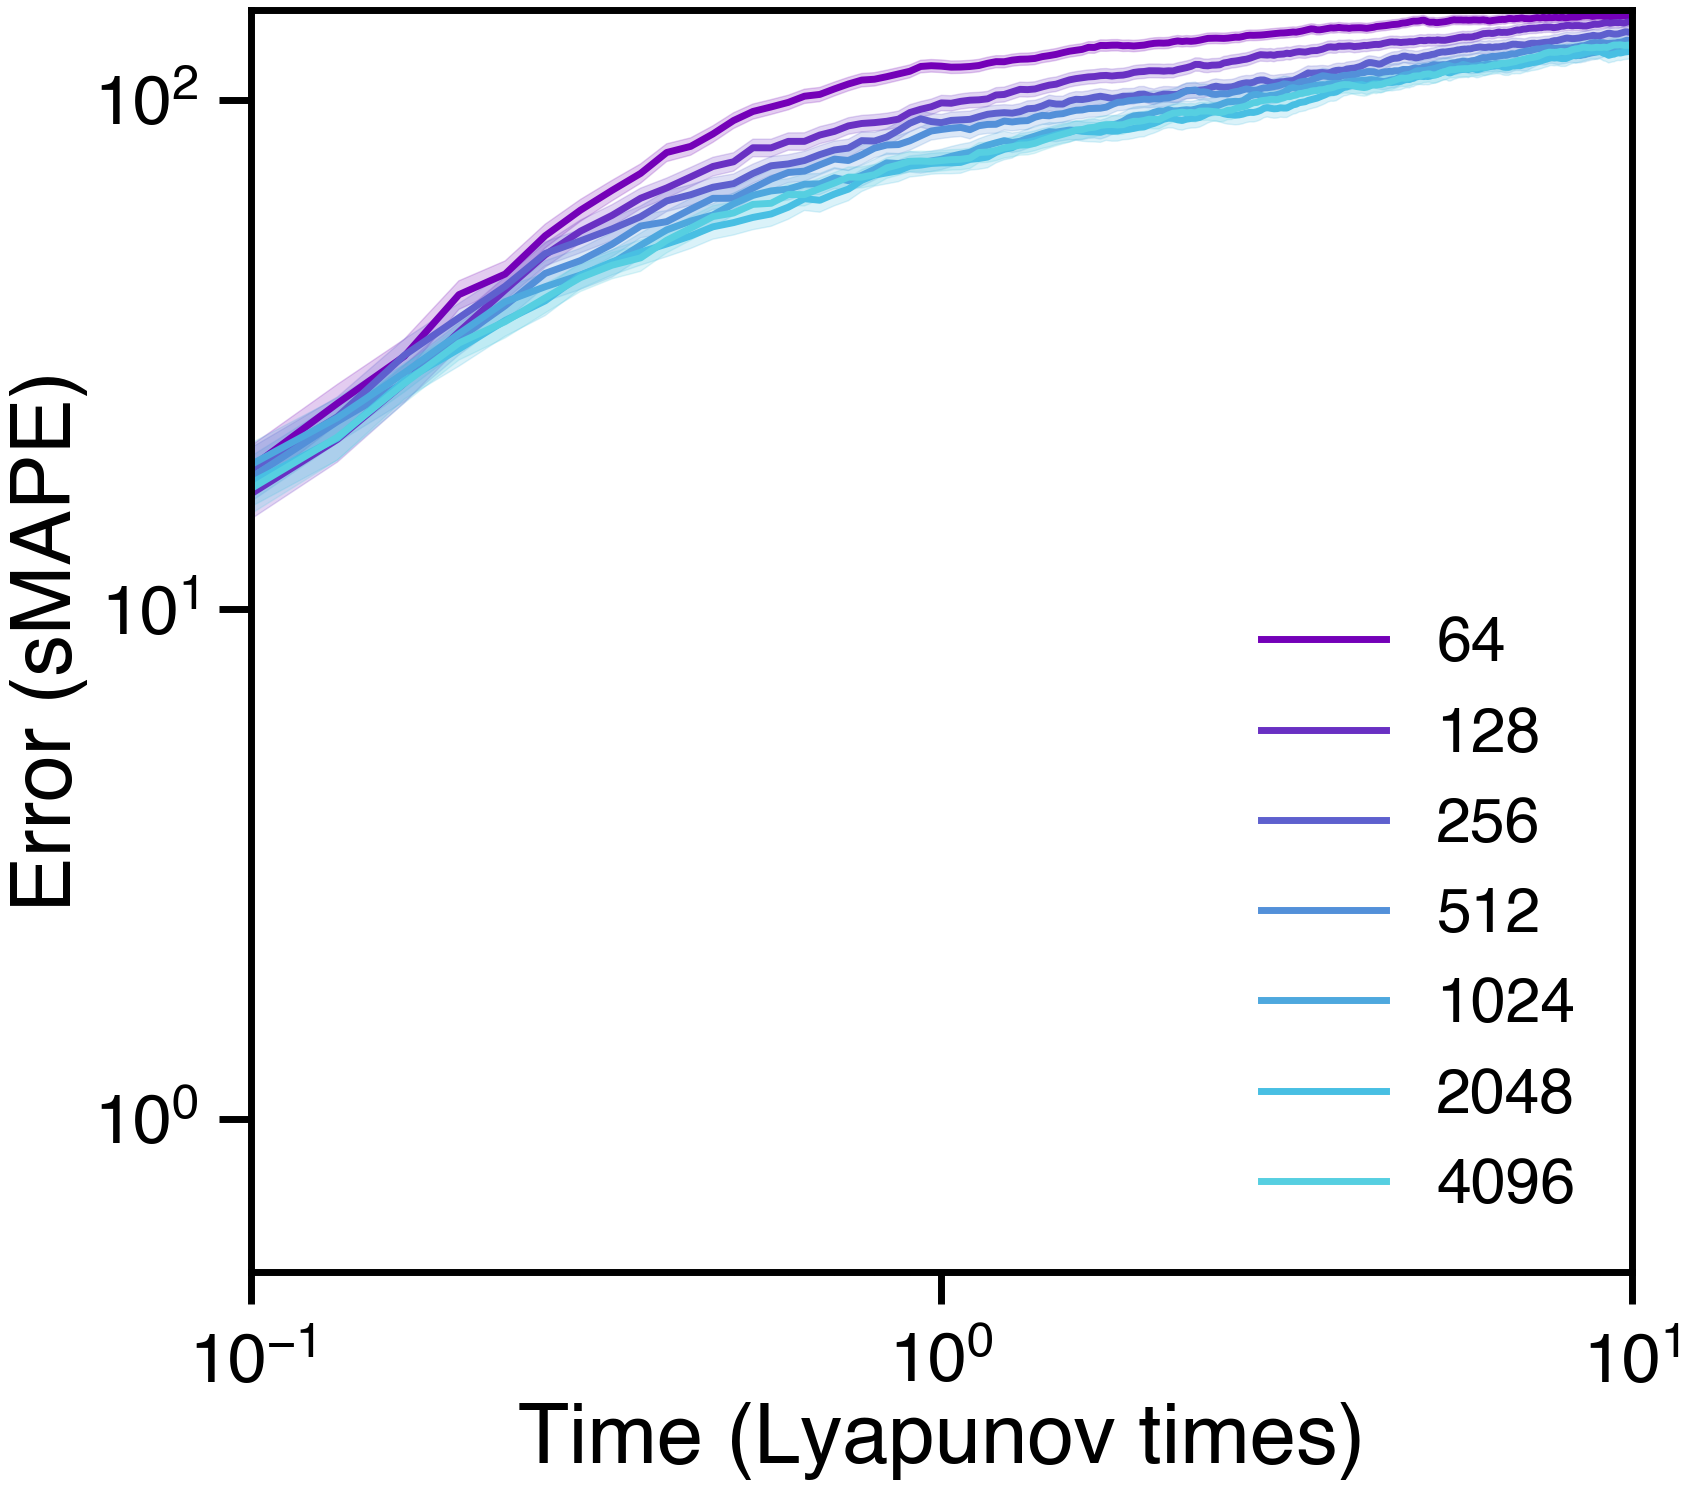

In [9]:
#import degas as dg
colors = ['#f94144', '#f3722c', '#f8961e', '#f9844a', '#f9c74f', '#90be6d', '#43aa8b', '#4d908e', '#577590', '#277da1']
colors = ["#7400b8","#6930c3","#5e60ce","#5390d9","#4ea8de","#48bfe3","#56cfe1","#64dfdf","#72efdd","#80ffdb"]

time = np.arange(1/granularity, (forecast_length+1)/granularity, 1/granularity)

# Plot Average VPT vs. Context Length for each equation
fig = plt.figure()
ax = fig.add_subplot(111)

for axis in ['bottom','left']:
  ax.spines[axis].set_linewidth(5)
for axis in ['top','right']:
  ax.spines[axis].set_linewidth(5)
  #ax.spines[axis].set_visible(False)

ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

fig.set_size_inches(17,15)
plt.xticks(fontsize = 50)
plt.yticks(fontsize = 50)
plt.xlabel(r'Time (Lyapunov times)', fontname="Helvetica", fontsize = 60)
plt.ylabel(r'Error (sMAPE)', fontname="Helvetica", fontsize = 60)
  
for i, context_length in enumerate(context_lengths):
  smape_trjs = [median_smape[(equation_name, context_length)] for equation_name, ctx in median_smape.keys() if ctx == context_length]
  smape_trj = np.median(smape_trjs, axis=0)
  smape_std = np.std(smape_trjs, axis=0)/np.sqrt(len(equation_names))
  plt.plot(time, smape_trj, lw=5, ls='-', alpha=1, color=colors[i], label=context_length)
  ax.fill_between(time, smape_trj - smape_std, smape_trj + smape_std, alpha=0.2, color=colors[i])
  #dg.plot_err(smape_trj, smape_std/1.0, x=time, color=colors[i], label=context_length, zorder=10*i)

plt.xscale('log')
plt.yscale('log')

plt.xlim([.1, 10])
plt.ylim([.5, 150])

plt.legend(loc='lower right', frameon=False, prop={'size':45}, ncol=1)

plt.gca().tick_params(axis='y', pad=15, size=23, width=5)
plt.gca().tick_params(axis='x', pad=20, size=23, width=5)

fig.set_tight_layout(True)
#plt.savefig(f'smape_rolling_chronos.pdf', bbox_inches='tight')